In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [2]:
DATADIR = "/content/gdrive/MyDrive/DL_dataset/observations-master.zip"
CATEGORIES = ['without_mask', 'with_mask']

In [3]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!unzip gdrive/My\ Drive/DL_dataset/observations-master.zip

Archive:  gdrive/My Drive/DL_dataset/observations-master.zip
cdcf4501bf7fdec7ac8a4ee245e343b187fa53c7
   creating: observations-master/
  inflating: observations-master/README.md  
   creating: observations-master/experiements/
   creating: observations-master/experiements/data/
   creating: observations-master/experiements/data/with_mask/
  inflating: observations-master/experiements/data/with_mask/0-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/1-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/10-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/100-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/101-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/103-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/104-with-mask.jpg  
  inflating: observations-master/experiements/data/with_mask/105-with-mask.jpg  
  inflating: ob

In [5]:
data_path = "observations-master/experiements/data"

In [6]:
categories=os.listdir(data_path)

In [7]:
print(categories)

['with_mask', 'without_mask']


In [8]:
labels=[i for i in range(len(categories))]
label_dict = dict(zip(categories,labels))

In [9]:
print(label_dict)

{'with_mask': 0, 'without_mask': 1}


In [10]:
dataset = {
    "image_path": [],
    "mask_status": [],
}

for status in os.listdir(data_path):
  for image in glob.glob(data_path+"/"+status+"/"+"*.jpg"):
    dataset["image_path"].append(image)
    dataset["mask_status"].append(status)
            
dataset = pd.DataFrame(dataset)
dataset.head(10)

,image_path,mask_status
0,observations-master/experiements/data/with_mas...,with_mask
1,observations-master/experiements/data/with_mas...,with_mask
2,observations-master/experiements/data/with_mas...,with_mask
3,observations-master/experiements/data/with_mas...,with_mask
4,observations-master/experiements/data/with_mas...,with_mask
5,observations-master/experiements/data/with_mas...,with_mask
6,observations-master/experiements/data/with_mas...,with_mask
7,observations-master/experiements/data/with_mas...,with_mask
8,observations-master/experiements/data/with_mas...,with_mask
9,observations-master/experiements/data/with_mas...,with_mask


In [11]:
dataset = dataset.sample(frac=1)
dataset.head(10)

,image_path,mask_status
1283,observations-master/experiements/data/without_...,without_mask
572,observations-master/experiements/data/with_mas...,with_mask
1240,observations-master/experiements/data/without_...,without_mask
1006,observations-master/experiements/data/without_...,without_mask
121,observations-master/experiements/data/with_mas...,with_mask
254,observations-master/experiements/data/with_mas...,with_mask
814,observations-master/experiements/data/without_...,without_mask
32,observations-master/experiements/data/with_mas...,with_mask
616,observations-master/experiements/data/with_mas...,with_mask
330,observations-master/experiements/data/with_mas...,with_mask


In [12]:
dataset = dataset.reset_index().drop("index", axis = 1)
dataset.head(10)

,image_path,mask_status
0,observations-master/experiements/data/without_...,without_mask
1,observations-master/experiements/data/with_mas...,with_mask
2,observations-master/experiements/data/without_...,without_mask
3,observations-master/experiements/data/without_...,without_mask
4,observations-master/experiements/data/with_mas...,with_mask
5,observations-master/experiements/data/with_mas...,with_mask
6,observations-master/experiements/data/without_...,without_mask
7,observations-master/experiements/data/with_mas...,with_mask
8,observations-master/experiements/data/with_mas...,with_mask
9,observations-master/experiements/data/with_mas...,with_mask


In [13]:
data = []
image_size = 100

for i in range(len(dataset)):
    ## Converting the image into grayscale
    img_array = cv2.imread(dataset["image_path"][i])
    img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))
    ## Normalize
    #norm_image = cv2.normalize(new_image_array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ## reshaping image
    #norm_image=np.reshape(norm_image,(norm_image.shape[0],image_size,image_size,1))
    ##Encoding the image with the label
    if dataset["mask_status"][i] == "with_mask":
        data.append([new_image_array, label_dict['with_mask']])
    else:
        data.append([new_image_array, label_dict['without_mask']])

In [14]:
data

[[array([[255, 254, 253, ..., 222, 217, 245],
         [255, 255, 255, ..., 218, 200, 226],
         [252, 252, 252, ..., 248, 249, 250],
         ...,
         [ 19,  17,  17, ..., 255, 254, 247],
         [ 17,  17,  17, ..., 255, 254, 243],
         [ 17,  16,  16, ..., 255, 254, 255]], dtype=uint8), 1],
 [array([[254,  65,  72, ..., 130, 127, 117],
         [254,  70,  77, ..., 105, 124, 117],
         [253,  74,  85, ..., 135, 122, 154],
         ...,
         [250, 225, 227, ..., 227, 227, 227],
         [252, 239, 242, ..., 239, 240, 240],
         [253, 254, 252, ..., 253, 254, 254]], dtype=uint8), 0],
 [array([[221, 216, 218, ..., 243, 224, 232],
         [232, 220, 216, ..., 118, 209, 241],
         [230, 221, 218, ...,  81, 131, 229],
         ...,
         [127, 126, 125, ..., 239, 239, 237],
         [173, 126, 127, ..., 239, 238, 238],
         [226, 208, 135, ..., 238, 237, 238]], dtype=uint8), 1],
 [array([[232, 232, 232, ..., 228, 228, 226],
         [232, 232, 232, ..

In [15]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

In [16]:
X

array([[[255, 254, 253, ..., 222, 217, 245],
        [255, 255, 255, ..., 218, 200, 226],
        [252, 252, 252, ..., 248, 249, 250],
        ...,
        [ 19,  17,  17, ..., 255, 254, 247],
        [ 17,  17,  17, ..., 255, 254, 243],
        [ 17,  16,  16, ..., 255, 254, 255]],

       [[254,  65,  72, ..., 130, 127, 117],
        [254,  70,  77, ..., 105, 124, 117],
        [253,  74,  85, ..., 135, 122, 154],
        ...,
        [250, 225, 227, ..., 227, 227, 227],
        [252, 239, 242, ..., 239, 240, 240],
        [253, 254, 252, ..., 253, 254, 254]],

       [[221, 216, 218, ..., 243, 224, 232],
        [232, 220, 216, ..., 118, 209, 241],
        [230, 221, 218, ...,  81, 131, 229],
        ...,
        [127, 126, 125, ..., 239, 239, 237],
        [173, 126, 127, ..., 239, 238, 238],
        [226, 208, 135, ..., 238, 237, 238]],

       ...,

       [[223, 209, 219, ...,  44,  49,  64],
        [190, 198, 189, ...,  47,  51,  56],
        [223, 182, 193, ...,  51,  49,  43

In [17]:
X = X/255

In [18]:
X

array([[[1.        , 0.99607843, 0.99215686, ..., 0.87058824,
         0.85098039, 0.96078431],
        [1.        , 1.        , 1.        , ..., 0.85490196,
         0.78431373, 0.88627451],
        [0.98823529, 0.98823529, 0.98823529, ..., 0.97254902,
         0.97647059, 0.98039216],
        ...,
        [0.0745098 , 0.06666667, 0.06666667, ..., 1.        ,
         0.99607843, 0.96862745],
        [0.06666667, 0.06666667, 0.06666667, ..., 1.        ,
         0.99607843, 0.95294118],
        [0.06666667, 0.0627451 , 0.0627451 , ..., 1.        ,
         0.99607843, 1.        ]],

       [[0.99607843, 0.25490196, 0.28235294, ..., 0.50980392,
         0.49803922, 0.45882353],
        [0.99607843, 0.2745098 , 0.30196078, ..., 0.41176471,
         0.48627451, 0.45882353],
        [0.99215686, 0.29019608, 0.33333333, ..., 0.52941176,
         0.47843137, 0.60392157],
        ...,
        [0.98039216, 0.88235294, 0.89019608, ..., 0.89019608,
         0.89019608, 0.89019608],
        [0.9

In [19]:
X=np.reshape(X,(X.shape[0],100,100,1))

In [20]:
X

array([[[[1.        ],
         [0.99607843],
         [0.99215686],
         ...,
         [0.87058824],
         [0.85098039],
         [0.96078431]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.85490196],
         [0.78431373],
         [0.88627451]],

        [[0.98823529],
         [0.98823529],
         [0.98823529],
         ...,
         [0.97254902],
         [0.97647059],
         [0.98039216]],

        ...,

        [[0.0745098 ],
         [0.06666667],
         [0.06666667],
         ...,
         [1.        ],
         [0.99607843],
         [0.96862745]],

        [[0.06666667],
         [0.06666667],
         [0.06666667],
         ...,
         [1.        ],
         [0.99607843],
         [0.95294118]],

        [[0.06666667],
         [0.0627451 ],
         [0.0627451 ],
         ...,
         [1.        ],
         [0.99607843],
         [1.        ]]],


       [[[0.99607843],
         [0.25490196],
         [0.28

In [21]:
X.shape[1:]

(100, 100, 1)

In [31]:
model = Sequential()
model.add(Conv2D(200, (3, 3), activation = "relu", input_shape=(100, 100,1)))#input kya hoga??
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(100, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 200)       2000      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 200)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 100)       180100    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 100)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dropout_1 (Dropout)         (None, 10000)            

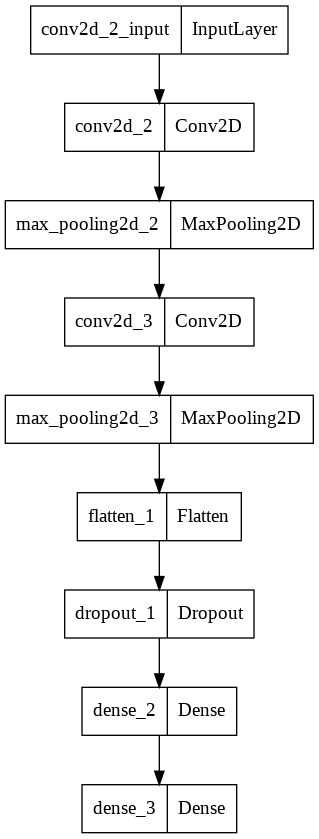

In [33]:
tf.keras.utils.plot_model(model)

In [34]:
opt = Adam(learning_rate=0.01)

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [36]:
history = model.fit(X_train, y_train, epochs=20, batch_size = 64,validation_data=(X_val, y_val))

Epoch 1/20
20/20 [==============================] - 2s 64ms/step - loss: 3.0630 - accuracy: 0.4693 - val_loss: 0.6988 - val_accuracy: 0.4565
Epoch 2/20
20/20 [==============================] - 1s 54ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6883 - val_accuracy: 0.5435
Epoch 3/20
20/20 [==============================] - 1s 53ms/step - loss: 0.6916 - accuracy: 0.5226 - val_loss: 0.6792 - val_accuracy: 0.5580
Epoch 4/20
20/20 [==============================] - 1s 54ms/step - loss: 0.6737 - accuracy: 0.5654 - val_loss: 0.6330 - val_accuracy: 0.5580
Epoch 5/20
20/20 [==============================] - 1s 54ms/step - loss: 0.6444 - accuracy: 0.6349 - val_loss: 0.5277 - val_accuracy: 0.7754
Epoch 6/20
20/20 [==============================] - 1s 53ms/step - loss: 0.5469 - accuracy: 0.7488 - val_loss: 0.3736 - val_accuracy: 0.8116
Epoch 7/20
20/20 [==============================] - 1s 55ms/step - loss: 0.4571 - accuracy: 0.8215 - val_loss: 0.2779 - val_accuracy: 0.8913
Epoch 8/20
20

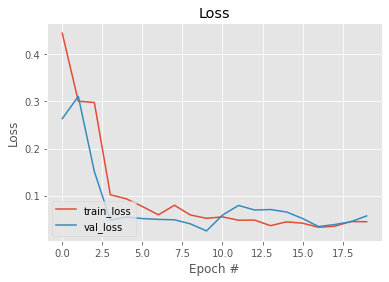

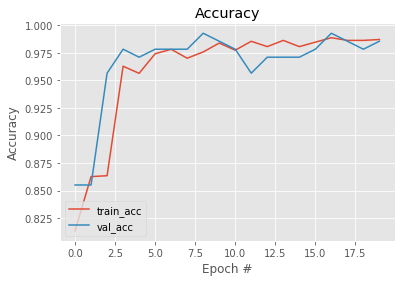

In [30]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")